In [1]:
%load_ext autoreload
%autoreload 2

import sys
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

sys.path.append('../dtu-deep-learning-project/src/')
from data_utils import *
clear_output(wait=False)

### Load dataset in the same order of the 12-fold cross validation (via random seed)

In [2]:
number_list=np.arange(0,12).tolist()
random.Random(17).shuffle(number_list)
print(number_list)
#user_seq = [10, 3, 0, 2, 7, 11, 1, 9, 5, 4, 6, 8]
user_seq = number_list

[10, 3, 0, 2, 7, 11, 1, 9, 5, 4, 6, 8]


### Load with data cleansing parameters

In [3]:
seq_cutoff_speed = 45
seq_cutoff_time = 60
filter_seq = 5
df = pd.concat([create_data_frame(*load_user_data(user,load_web_mercator = True), segmentation=True, seq_cutoff_time = seq_cutoff_time, seq_cutoff_speed = seq_cutoff_speed) for user in user_seq]).reset_index(drop=True)

In [4]:
df.head()

,user,ts,image_ix,x,y,label,x_web,y_web,delta_t,delta_d,bearing,speed,tod,segment_id,segment_ix,segment_point_count
0,10,2018-06-27 09:48:53,1,711532.908658,6.188468e+06,1,1.377536e+06,7.517802e+06,54.0,14.496543,-0.417844,0.268455,1,0,0,2
1,10,2018-06-27 09:49:41,2,711521.053121,6.188472e+06,1,1.377516e+06,7.517810e+06,48.0,12.545150,2.808481,0.261357,1,0,1,2
2,10,2018-06-27 09:50:47,3,711523.496849,6.188475e+06,1,1.377520e+06,7.517815e+06,66.0,3.860699,0.885406,0.058495,1,1,0,7
3,10,2018-06-27 09:51:17,4,711519.659310,6.188474e+06,1,1.377513e+06,7.517813e+06,30.0,4.023287,-2.836542,0.134110,1,1,1,7
4,10,2018-06-27 09:51:45,5,711529.724845,6.188474e+06,1,1.377531e+06,7.517812e+06,28.0,10.071304,-0.033849,0.359689,1,1,2,7


In [5]:
#plot_filtered(df[(df['user']==7)],'label')

In [6]:
#plot_filtered(df[(df['user']==9)],'label')

In [7]:
#plot_filtered(df[(df['user']==10)],'label')

### Load results from experiments

In [8]:
df2 = pd.DataFrame({
        'Infostop12fold' : np.load('resClust12fold.npy')[:,0],
        'RF12fold' : np.load('resRF12fold.npy')[:,0],
        'RNN12fold50EpSh' : np.load('resRNN12fold50Sh.npy')[:,0],
        'RF12foldDummies' : np.load('resRF12foldDummies.npy')[:,0],
        'RNN12fold50EpDummiesSh' : np.load('resRNN12fold50dummiesSh.npy')[:,0], 
        'RNNCNN12fold50Sh' : np.load('resRNNCNN12fold50Sh.npy')[:,0],
        'support' : [np.int(i) for i in np.load('resRF12fold.npy')[:,2]],
        'supportBC' : [df['user'][(df['user']==i)].count() for i in user_seq]
    })
df2['weight']=df2.support/df2.support.sum()

### Box plot of results from pandas (this is the average of F1 average, and it is not weighted on the size of the TE set

<AxesSubplot:title={'center':'Benchmark on 12-fold cross validation'}, xlabel='Classifier name', ylabel='F1-average'>

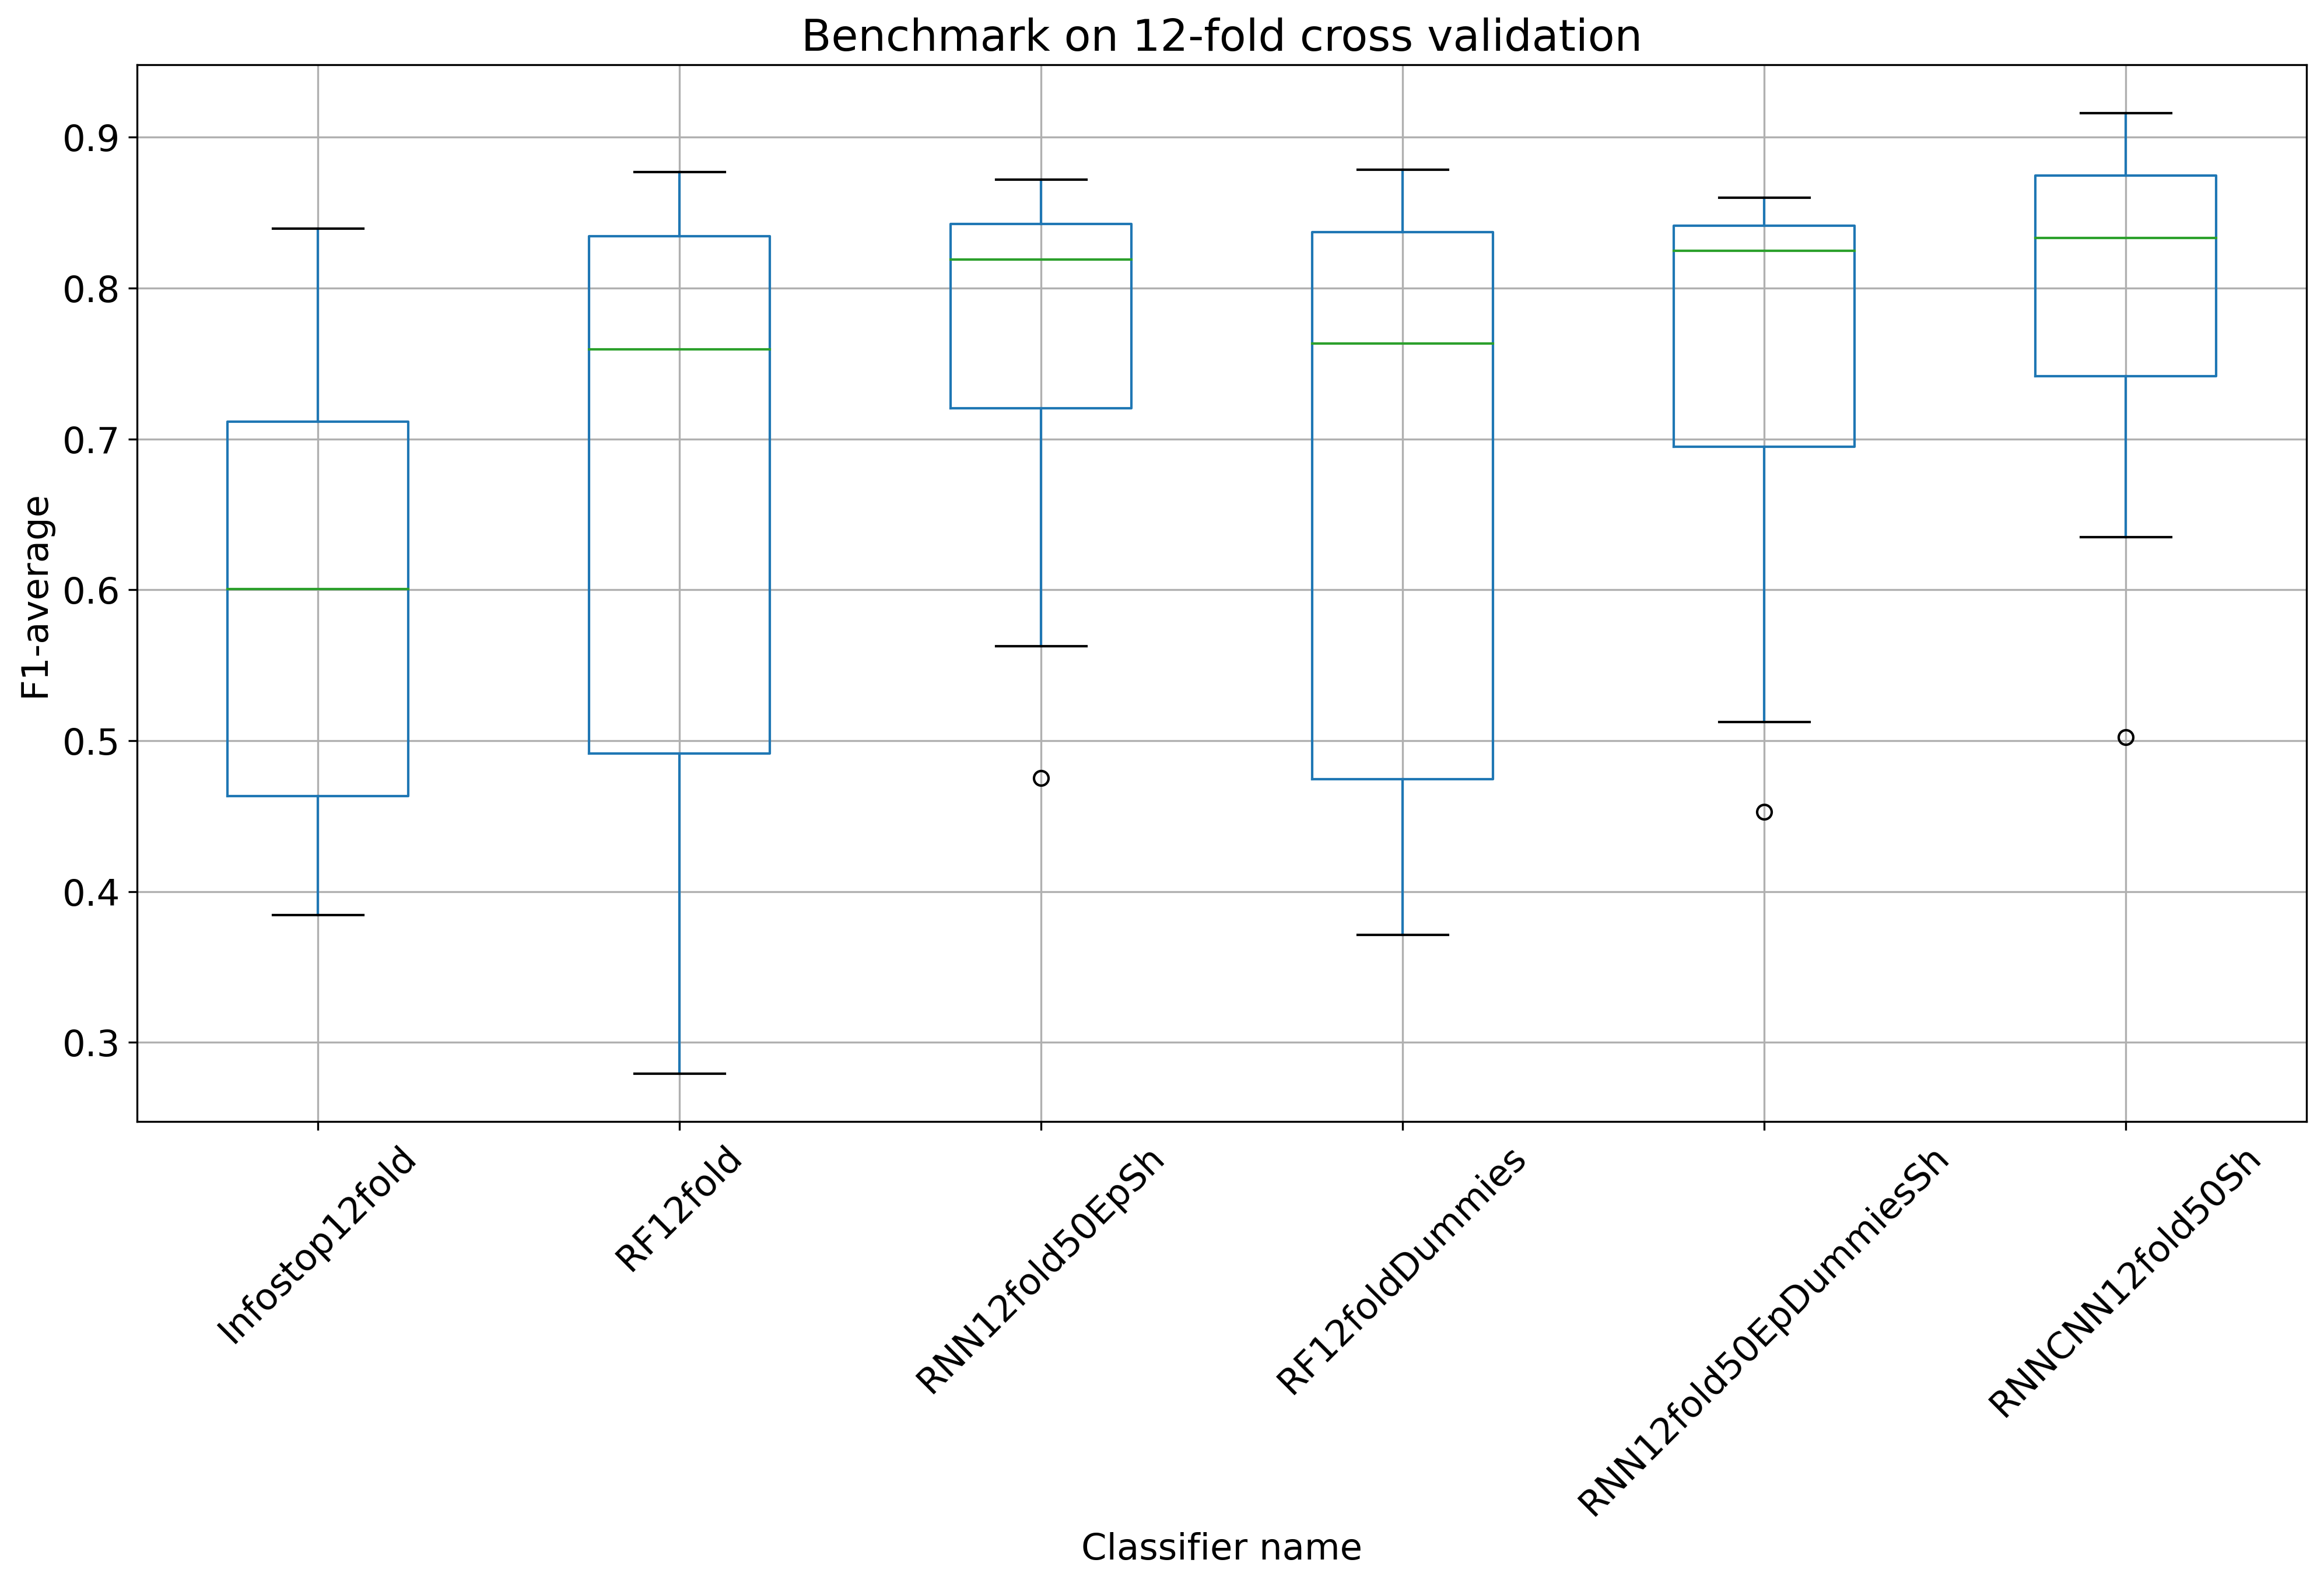

In [9]:
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['font.size'] = 15
plt.rcParams['figure.dpi'] = 300
plt.title('Benchmark on 12-fold cross validation')
plt.xlabel('Classifier name')
plt.ylabel('F1-average')
df2.boxplot(column=list(df2.columns)[:-3], rot=45, fontsize=15)

### Load and organize dataframe for Precision and Recall across 12-fold experiment

In [10]:
exps = ['classification_test_RNNCNN12fold50Sh'
        ,'classification_test_performanceRNN12fold50Sh'
        ,'classification_test_performanceRNN12fold50dummiesSh'
        ,'classification_test_performanceRF12fold'
        , 'classification_test_RF12foldDummies'
        , 'classification_test_performanceClust12fold']

def dataframeScoreFromDic(fileName, exps, expSh = ['RNNCNN12fold50Sh'
        ,'RNN12fold50Sh'
        ,'RNN12fold50dummiesSh'
        ,'RF12fold'
        ,'RF12foldDummies'
        ,'Infostop12fold']):
    '''
    LOAD DATAFRAME OF PRECISION AND RECALL BY CLASS AND MODEL
    '''
    df3 = pd.DataFrame({
        'Precision' : [n[c]['precision'] for i,n in enumerate(np.load(f'{fileName}.npy',allow_pickle=True)) for c in ['Motion','Stop']],
        'Recall' : [n[c]['recall'] for i,n in enumerate(np.load(f'{fileName}.npy',allow_pickle=True)) for c in ['Motion','Stop']],
        'Class' : [c for i,n in enumerate(np.load(f'{fileName}.npy',allow_pickle=True)) for j,c in enumerate(['Motion','Stop'])],
        'Model' : [expSh[exps.index(f'{fileName}')] for i,n in enumerate(np.load(f'{fileName}.npy',allow_pickle=True)) for j,c in enumerate(['Motion','Stop'])],
    })
    return df3
df3 = pd.concat([dataframeScoreFromDic(m, exps) for m in exps])

## Box Plot of Precision across 12-fold experiment

<AxesSubplot:title={'center':'Precision'}, xlabel='[Class, Model]'>

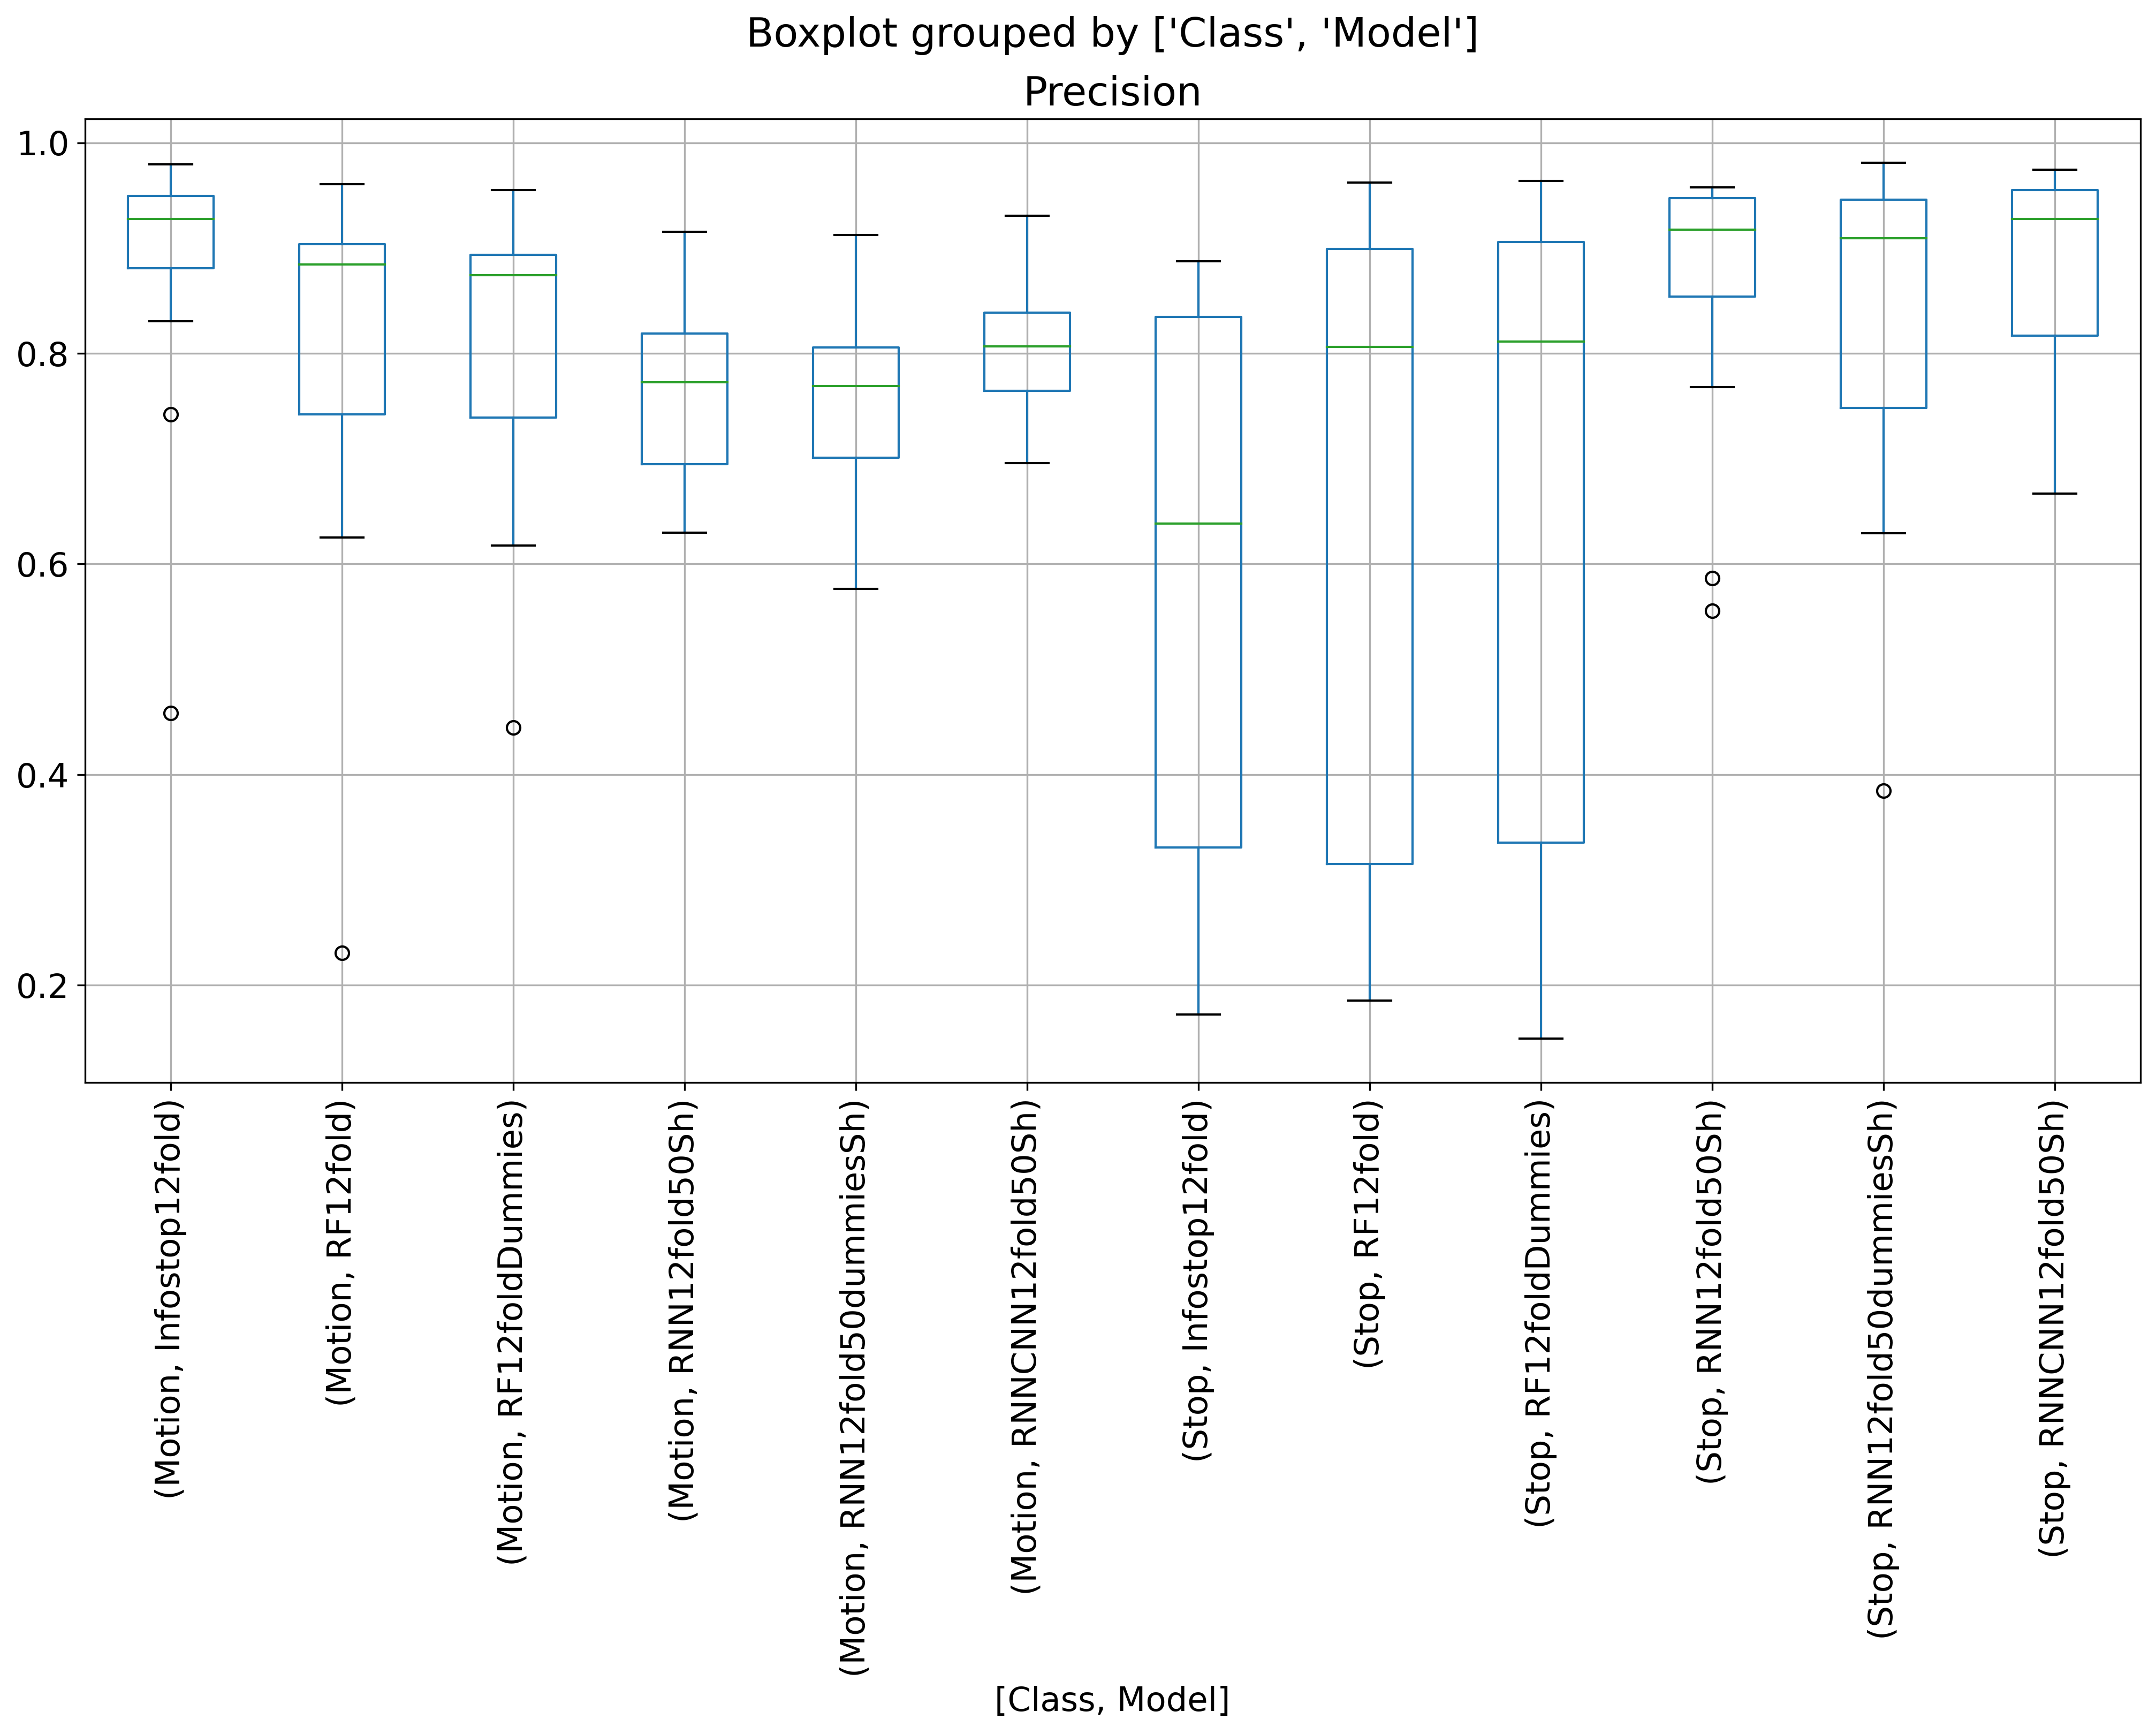

In [11]:
df3.boxplot(column=['Precision'], by=['Class', 'Model'], rot=90, fontsize=15)

## Box Plot of Recall across 12-fold experiment

<AxesSubplot:title={'center':'Recall'}, xlabel='[Class, Model]'>

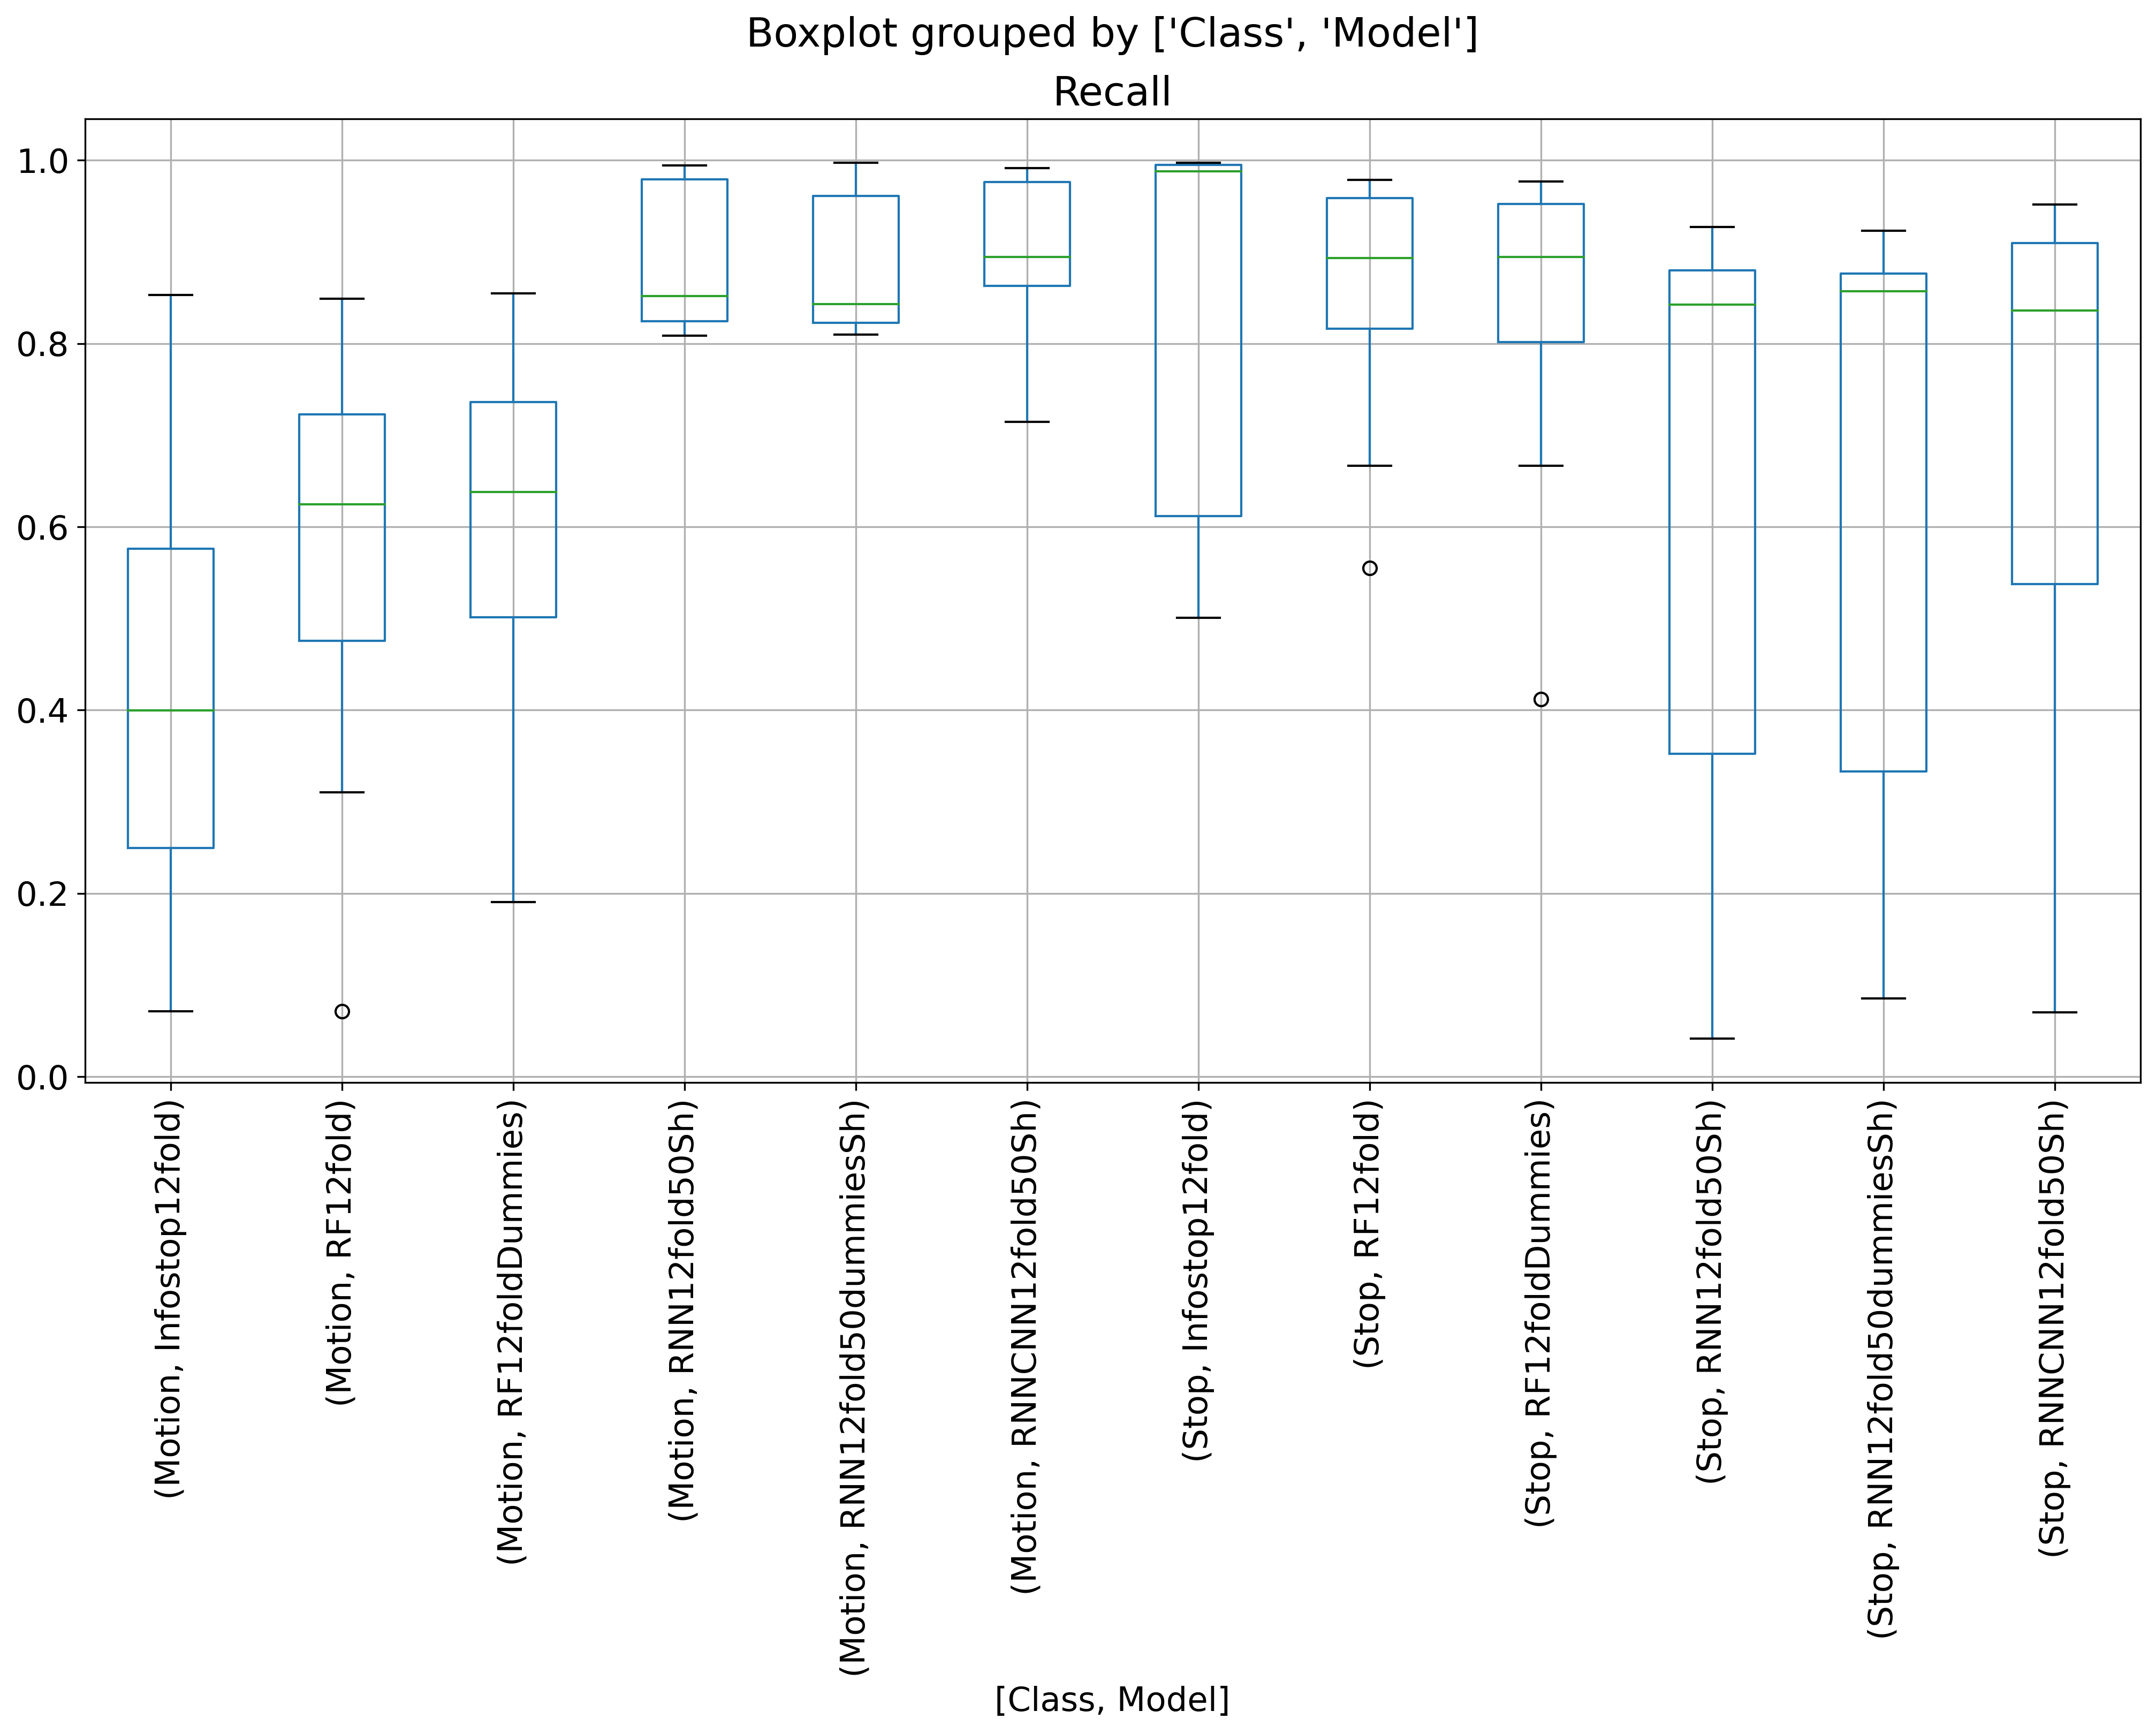

In [12]:
df3.boxplot(column=['Recall'], by=['Class', 'Model'], rot=90, fontsize=15)

### Delta F1 among methods

In [13]:
df2['deltaF1-'+df2.columns[0]] = df2['RNNCNN12fold50Sh']-df2[df2.columns[0]]
df2['deltaF1-'+df2.columns[1]] = df2['RNNCNN12fold50Sh']-df2[df2.columns[1]]
df2['deltaF1-'+df2.columns[2]] = df2['RNNCNN12fold50Sh']-df2[df2.columns[2]]
df2['deltaF1-'+df2.columns[3]] = df2['RNNCNN12fold50Sh']-df2[df2.columns[3]]
df2['deltaF1-'+df2.columns[4]] = df2['RNNCNN12fold50Sh']-df2[df2.columns[4]]
df2['deltaSupport'] = (df2['supportBC']-df2['support'])/df2['supportBC']

In [14]:
df2

,Infostop12fold,RF12fold,RNN12fold50EpSh,RF12foldDummies,RNN12fold50EpDummiesSh,RNNCNN12fold50Sh,support,supportBC,weight,deltaF1-Infostop12fold,deltaF1-RF12fold,deltaF1-RNN12fold50EpSh,deltaF1-RF12foldDummies,deltaF1-RNN12fold50EpDummiesSh,deltaSupport
0,0.709024,0.606729,0.699865,0.643104,0.699642,0.721314,1601,2322,0.001121,0.012290,0.114585,0.021449,0.078210,0.021672,0.310508
1,0.817397,0.847378,0.833908,0.850183,0.838481,0.869847,79277,82112,0.055504,0.052450,0.022469,0.035939,0.019664,0.031365,0.034526
2,0.839551,0.876957,0.840159,0.877118,0.837283,0.916005,84464,85342,0.059136,0.076454,0.039048,0.075846,0.038887,0.078722,0.010288
3,0.456760,0.830216,0.831274,0.832931,0.829813,0.829793,115564,116552,0.080910,0.373032,-0.000424,-0.001482,-0.003138,-0.000020,0.008477
4,0.410251,0.410031,0.475436,0.397952,0.512563,0.502142,10192,14037,0.007136,0.091891,0.092110,0.026705,0.104190,-0.010422,0.273919
5,0.552835,0.732222,0.860183,0.740311,0.854069,0.891590,28015,28478,0.019614,0.338755,0.159368,0.031407,0.151279,0.037522,0.016258
6,0.671460,0.869532,0.871743,0.878558,0.859794,0.889273,644665,656635,0.451351,0.217813,0.019741,0.017530,0.010715,0.029479,0.018229
7,0.384615,0.279265,0.562500,0.371429,0.452913,0.748252,72,111,0.000050,0.363636,0.468987,0.185752,0.376823,0.295339,0.351351
8,0.718039,0.786410,0.806717,0.786007,0.819559,0.836701,17328,17679,0.012132,0.118662,0.050292,0.029984,0.050694,0.017143,0.019854
9,0.631189,0.820841,0.850214,0.818313,0.849603,0.867399,417726,422271,0.292463,0.236210,0.046559,0.017186,0.049086,0.017796,0.010763


### Correlation matrix between each method performance and Noise_{GPS_u}

In [15]:
corrMatrix = df2[['Infostop12fold','RF12fold','RNN12fold50EpSh','RF12foldDummies','RNN12fold50EpDummiesSh','RNNCNN12fold50Sh','deltaSupport']].corr()

## Compute average of F1-score and F1-std, weighted on the TE size of each fold, method by method

In [17]:
dfT = pd.DataFrame({      
        'F1-score' : [np.average(df2[c], weights=df2['weight'].values) for c in list(df2.columns)[:-2] if c in ['Infostop12fold','RF12fold','RNN12fold50EpSh','RF12foldDummies','RNN12fold50EpDummiesSh','RNNCNN12fold50Sh']] ,
        'F1-std' : np.sqrt([ np.average((df2[c]-np.average(df2[c], weights=df2['weight'].values))**2, weights=df2['weight'].values) for c in list(df2.columns)[:-2] if c in ['Infostop12fold','RF12fold','RNN12fold50EpSh','RF12foldDummies','RNN12fold50EpDummiesSh','RNNCNN12fold50Sh']]),
         'method' : ['Infostop12fold','RF12fold','RNN12fold50EpSh','RF12foldDummies','RNN12fold50EpDummiesSh','RNNCNN12fold50Sh']
    }).set_index('method')

In [18]:
dfT

,F1-score,F1-std
method,,
Infostop12fold,0.653599,0.089845
RF12fold,0.836002,0.070067
RNN12fold50EpSh,0.851600,0.039219
RF12foldDummies,0.839714,0.073009
RNN12fold50EpDummiesSh,0.845509,0.036765
RNNCNN12fold50Sh,0.871712,0.044977


### Plot KPIs method by method 

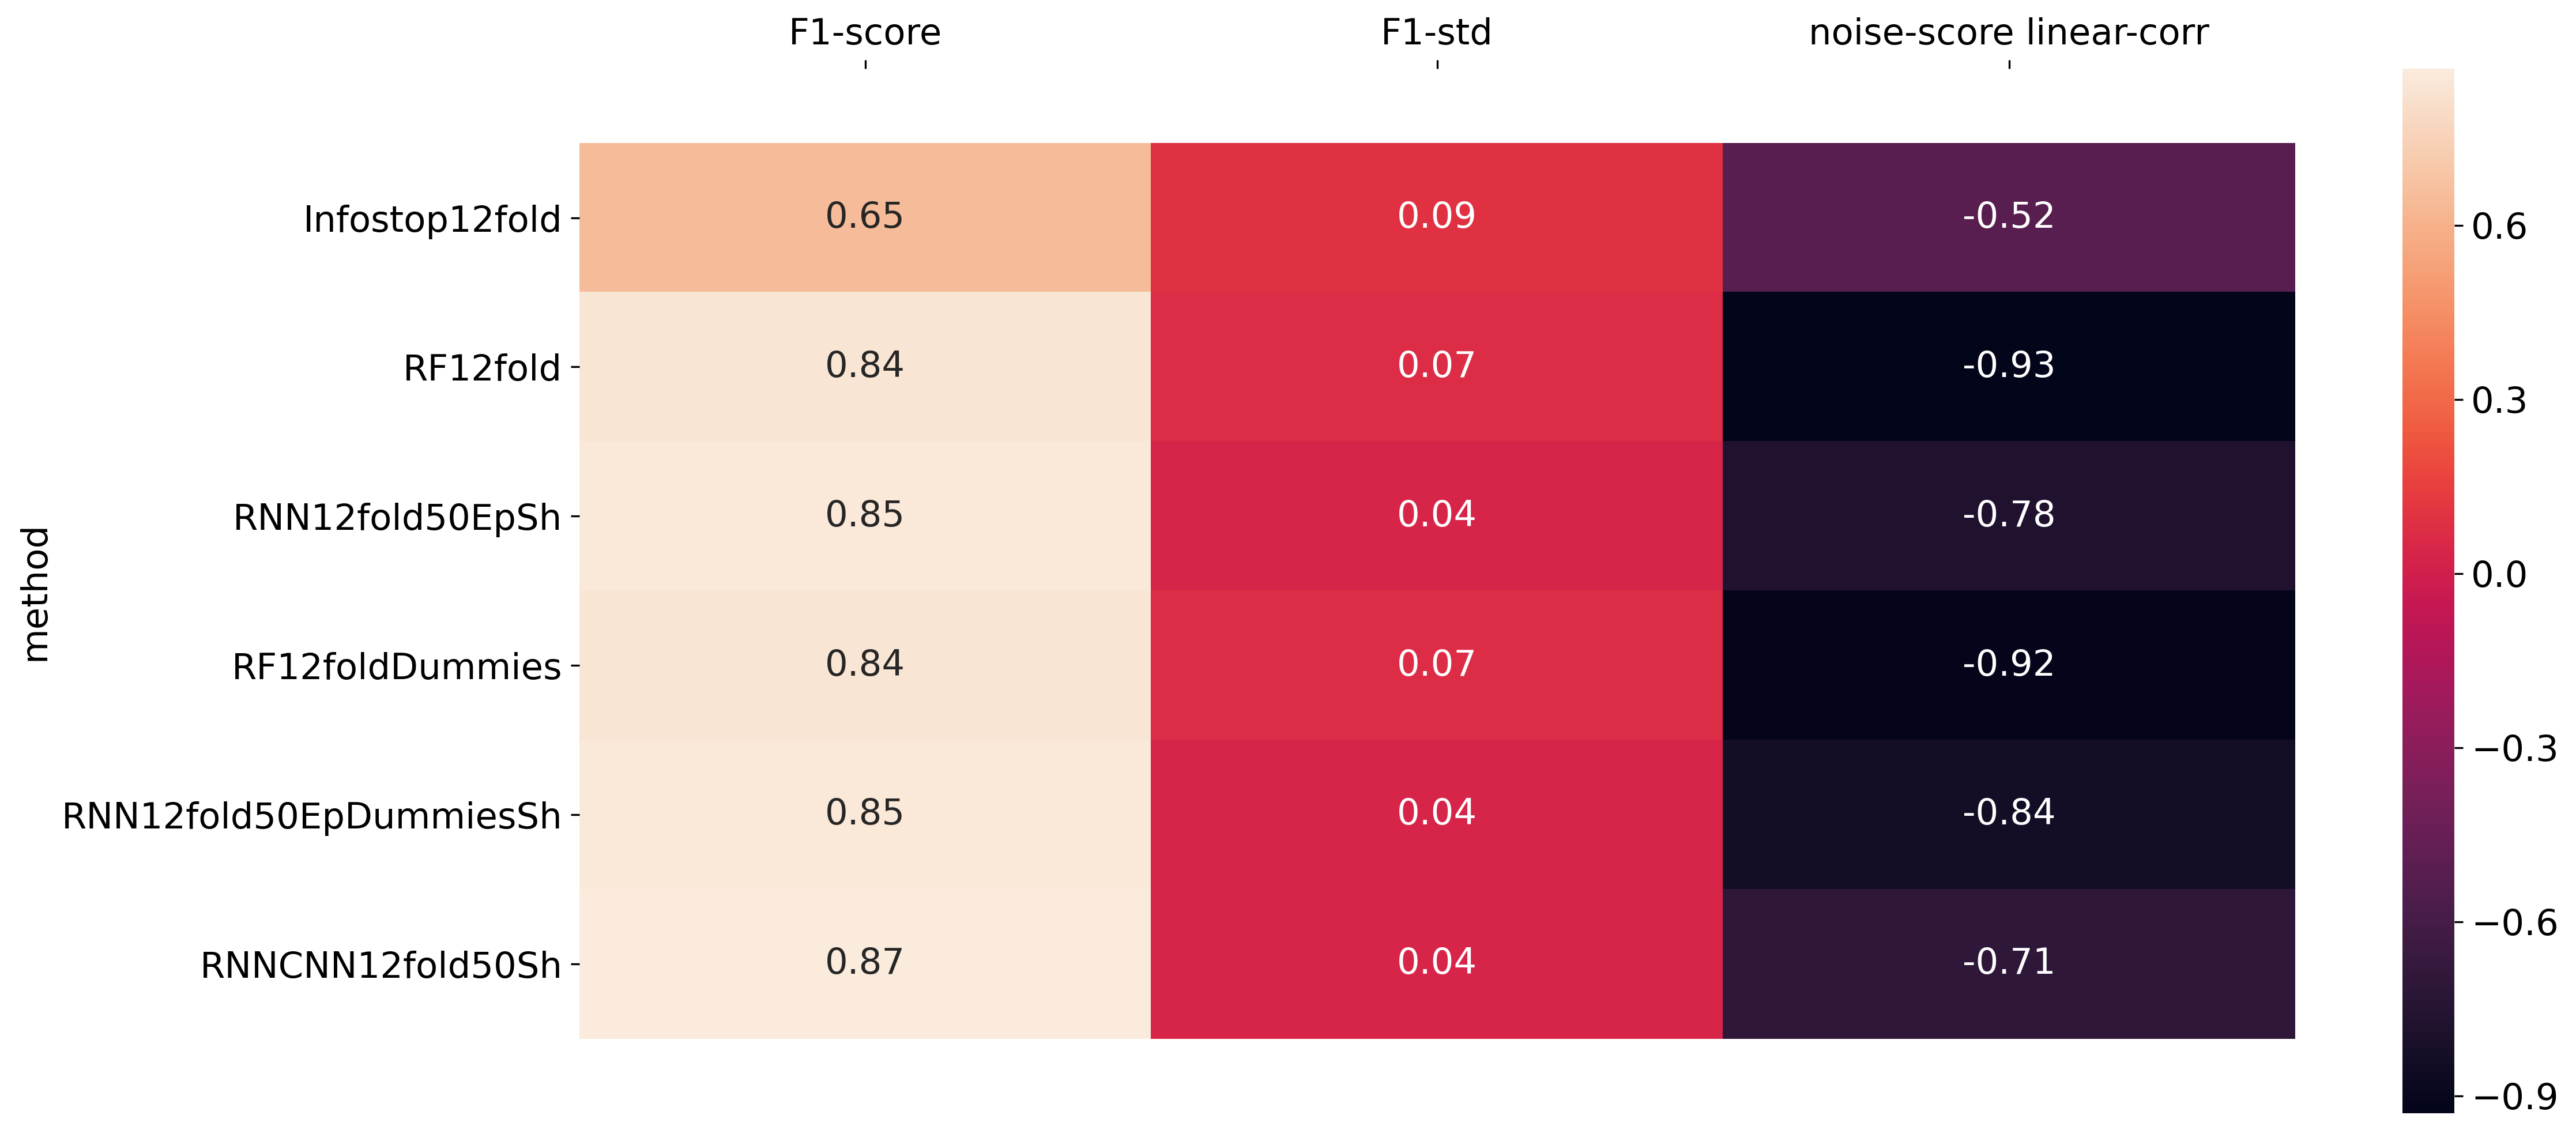

In [19]:
import seaborn as sn
dfT.loc[:,'noise-score linear-corr'] = corrMatrix[corrMatrix.columns[-1:]].iloc[0:6]
fig, ax = plt.subplots()
sn.heatmap(dfT.round(2), annot=True)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
#plt.title('F1-score correlation ')
plt.ylim(b, t) # update the ylim(bottom, top) values
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
plt.show() # ta-da!

In [20]:
dfT.round(2)

,F1-score,F1-std,noise-score linear-corr
method,,,
Infostop12fold,0.65,0.09,-0.52
RF12fold,0.84,0.07,-0.93
RNN12fold50EpSh,0.85,0.04,-0.78
RF12foldDummies,0.84,0.07,-0.92
RNN12fold50EpDummiesSh,0.85,0.04,-0.84
RNNCNN12fold50Sh,0.87,0.04,-0.71


### Box plot of F1-average, weighted on the sample size of each of the 12 TE partitions

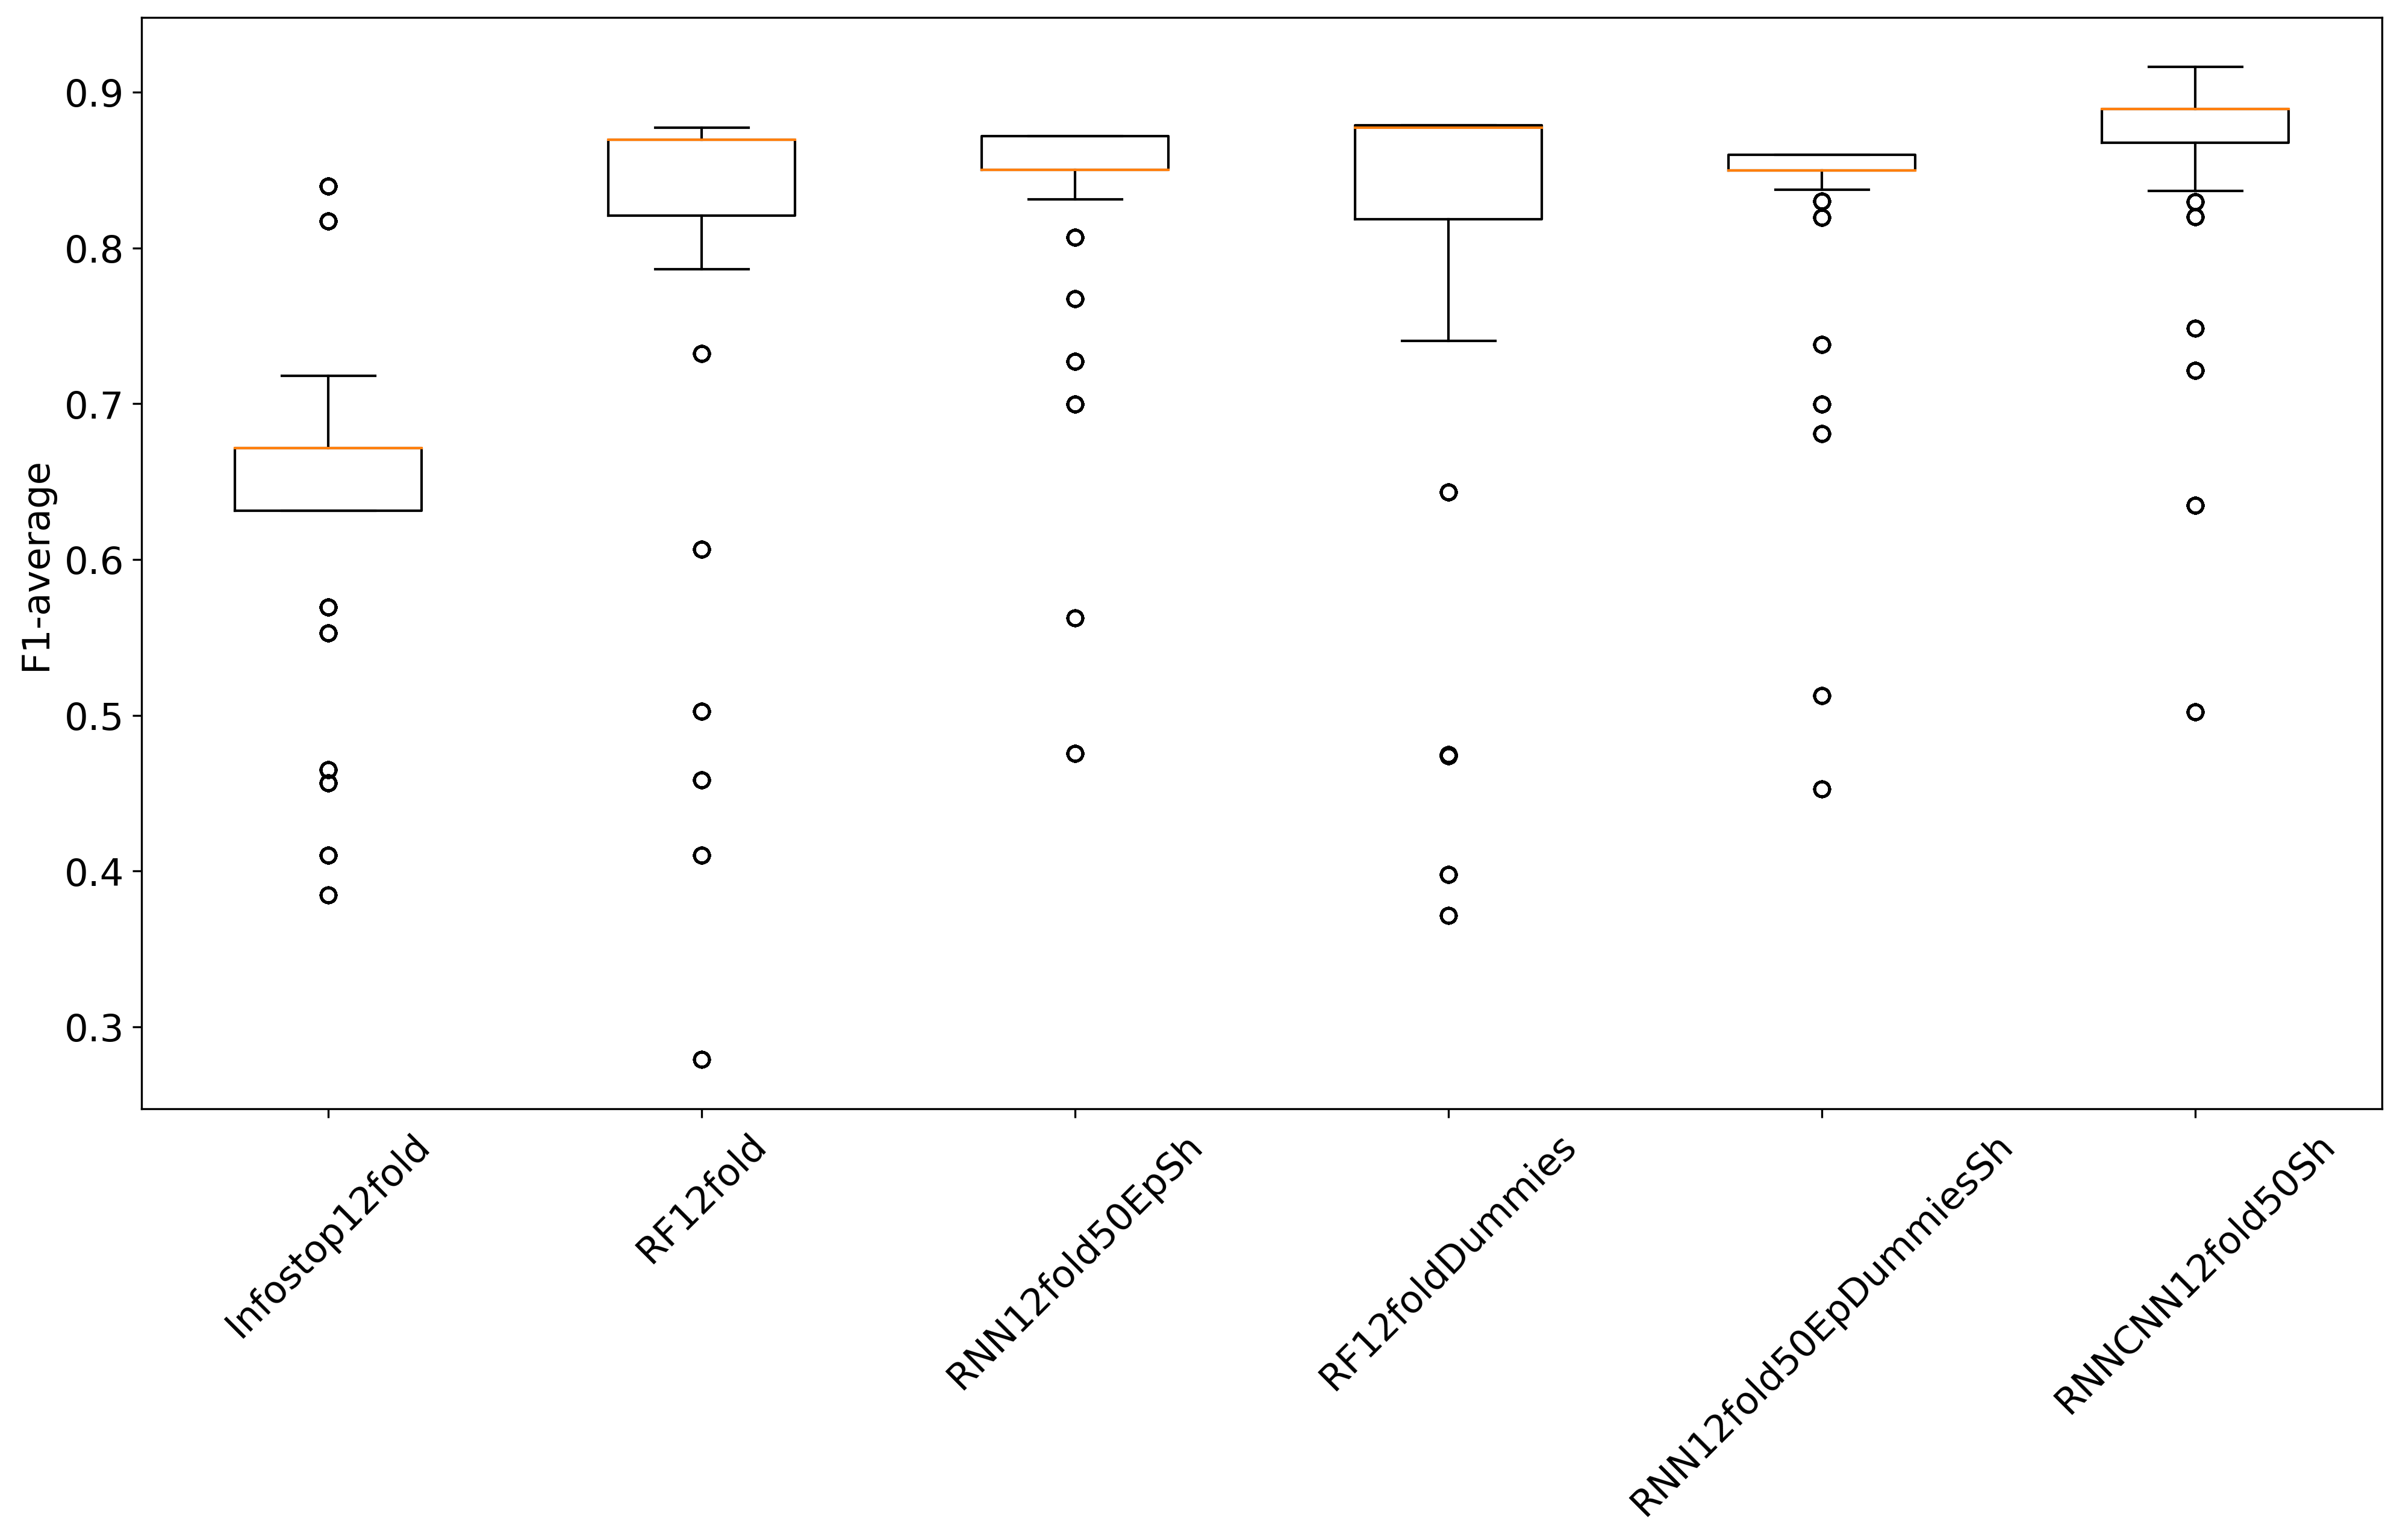

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def printBoxPlot(df):
    
    col_weighted_appearances = []
    for c in df.columns:
        if c in ['Infostop12fold','RF12fold','RNN12fold50EpSh','RF12foldDummies','RNN12fold50EpDummiesSh','RNNCNN12fold50Sh']:
            weighted_appearances = []
            for index, row in df.iterrows():
                    weighted_row = [row[c]]*np.int(row.support)
                    weighted_appearances += weighted_row
            col_weighted_appearances.append(weighted_appearances)
    
    fig, ax = plt.subplots(figsize=(16, 8)) 
    #fig = plt.figure(1, figsize=(16, 8))
    
    #plt.title('title')
    #plt.xlabel('xAxis')
    plt.ylabel('F1-average')
    

    plt.boxplot(col_weighted_appearances, meanline=True)
    ax.set_xticklabels(list(df2.columns)[:-9], rotation=45, fontsize=15)
    plt.savefig('test.png', dpi=300)
    

    plt.show()
printBoxPlot(df2)

### Plot F1 distribution, not weighted

<AxesSubplot:ylabel='Density'>

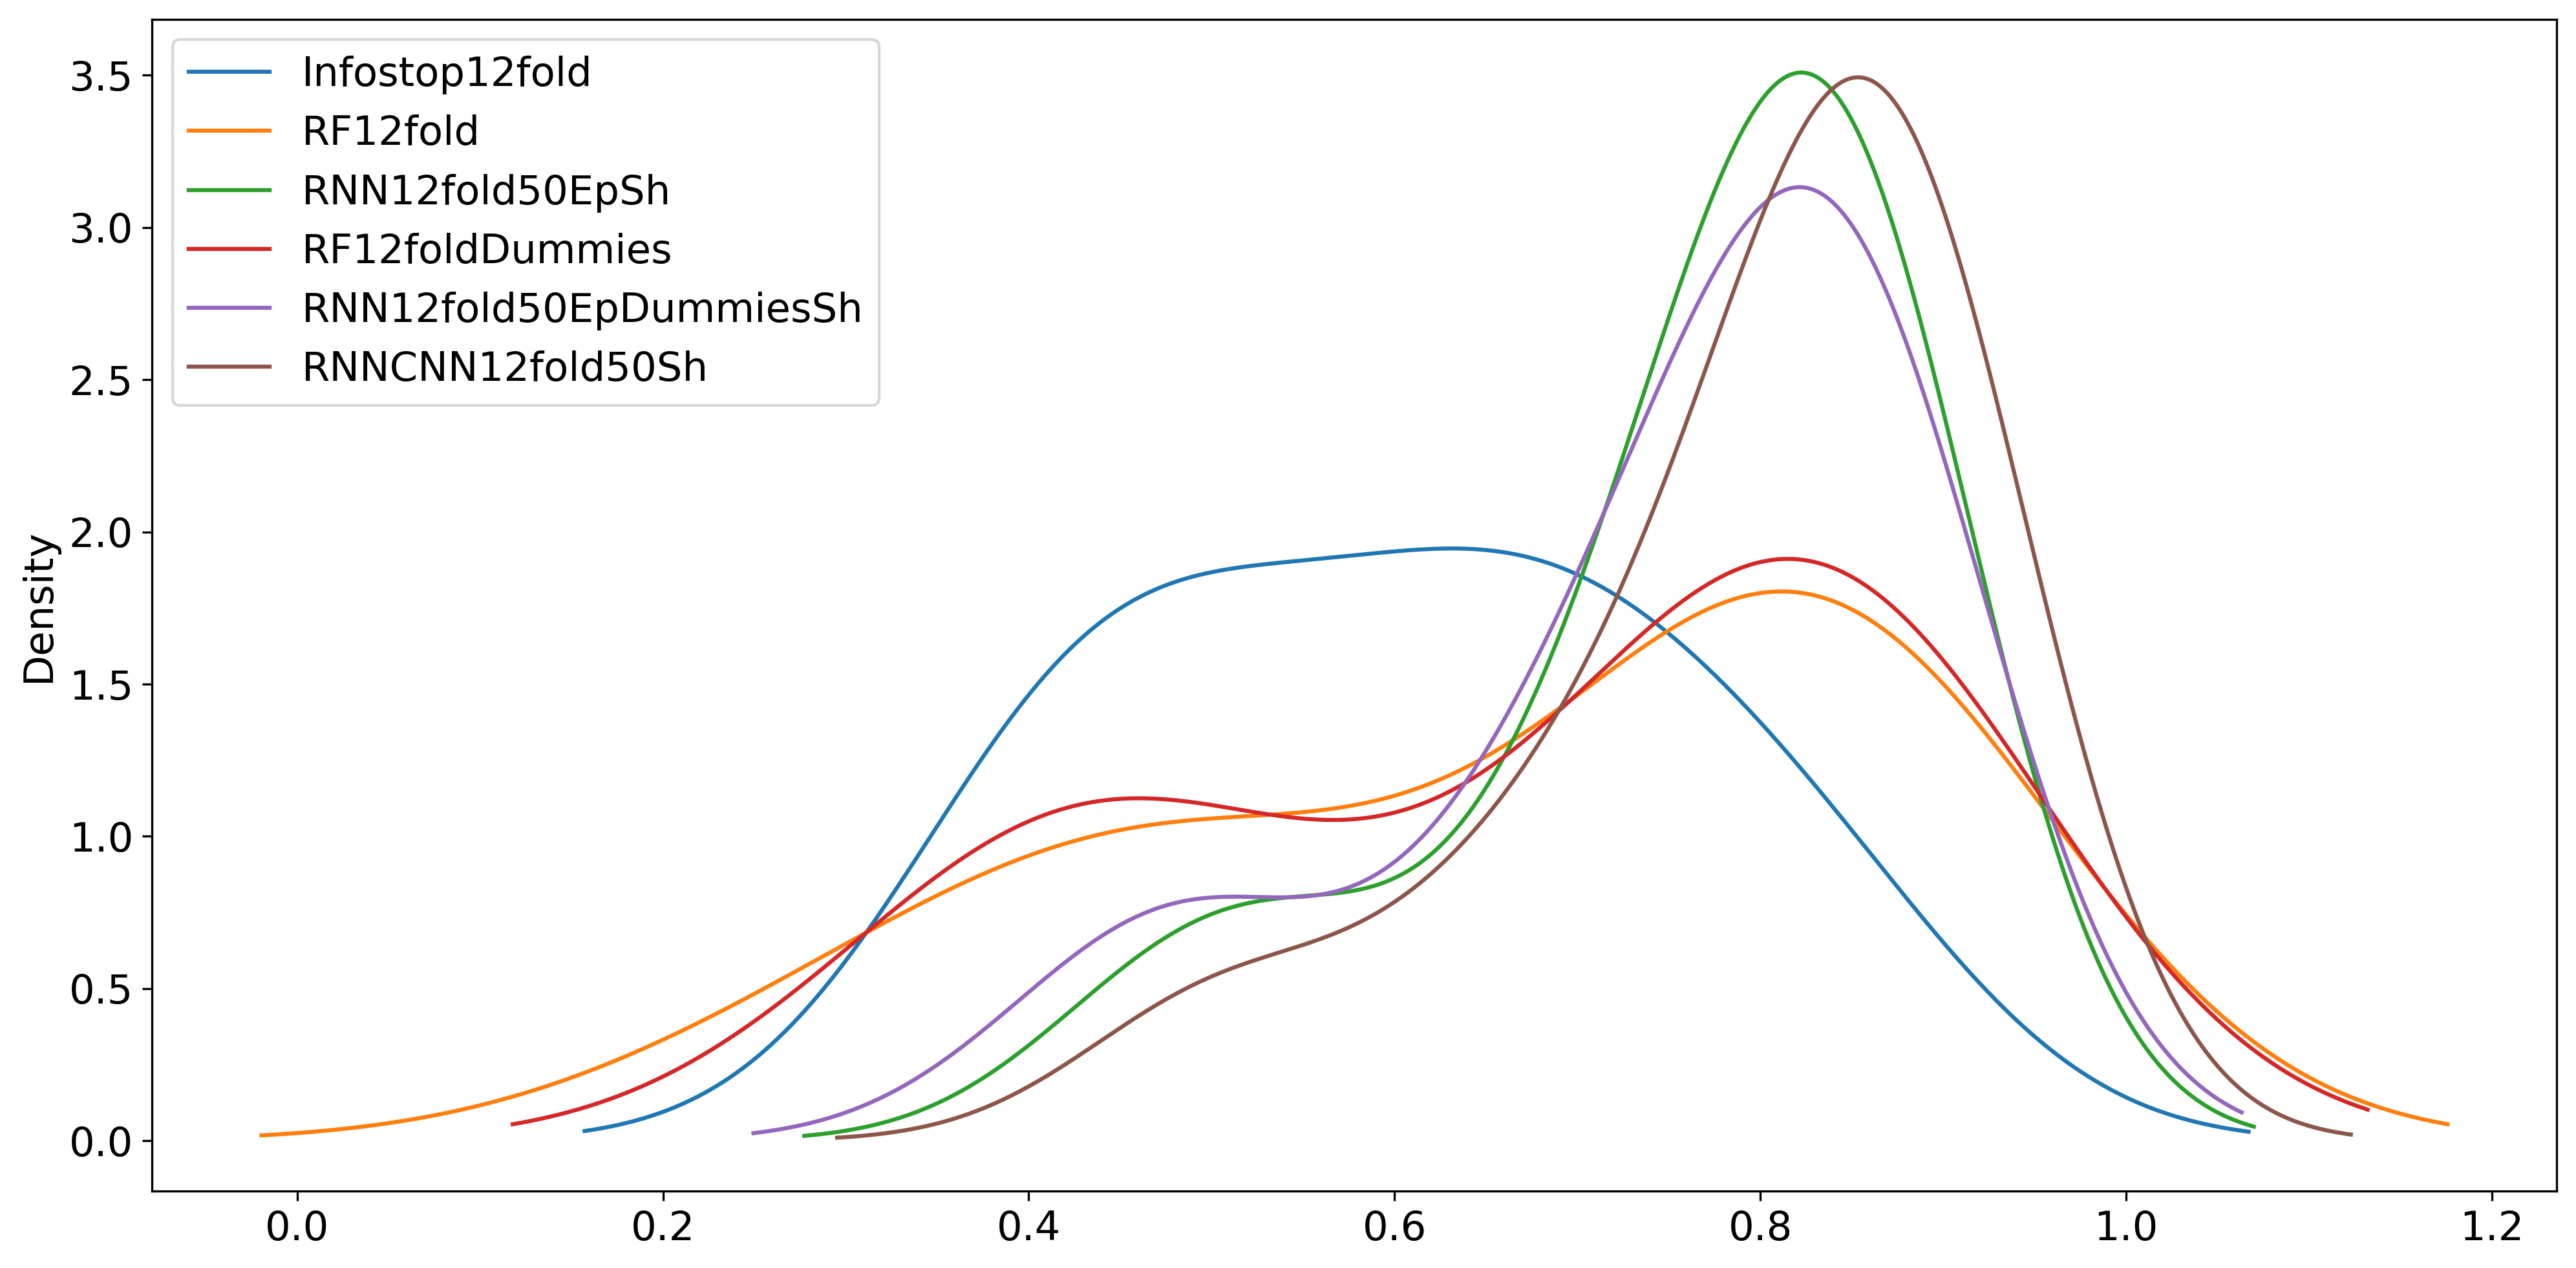

In [22]:
df2[[c for c in df2.columns if c in ['Infostop12fold','RF12fold','RNN12fold50EpSh','RF12foldDummies','RNN12fold50EpDummiesSh','RNNCNN12fold50Sh']]].plot.kde()

### Delta F1-average between best and worst method

In [23]:
df2[[c for c in ['Infostop12fold','RF12fold','RNN12fold50EpSh','RF12foldDummies','RNN12fold50EpDummiesSh','RNNCNN12fold50Sh']]].mean().max()-df2[[c for c in ['Infostop12fold','RF12fold','RNN12fold50EpSh','RF12foldDummies','RNN12fold50EpDummiesSh','RNNCNN12fold50Sh']]].mean().min()

0.19175160505018252

### Delta F1-average between Best and Random Forest

In [24]:
[(np.average(df2['RNNCNN12fold50Sh']-df2[c], weights=df2['weight'].values), f'RNNCNN12fold50Sh-{c}') for c in list(df2.columns)[:-2] if c=='RF12foldDummies' or c=='RF12fold'] 
#df2[[c for c in df2.columns if (c != 'support') & (c != 'weight')]].mean()

[(0.03570996915945438, 'RNNCNN12fold50Sh-RF12fold'),
 (0.03199788937523435, 'RNNCNN12fold50Sh-RF12foldDummies')]